In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt 
import pickle 
from IPython.core.debugger import set_trace

import torch 
import argparse
from utils.nnet import get_device 
from utils.data import gen_datasets 
from utils.eval import perform_rsa_cnn
from trainer import train_cnn 
from parameters import parser
from pathlib import Path 
import datetime 
from models import CustomAlexNet


In [2]:
# model with default weight init (He init)
nnet = CustomAlexNet(pretrained=False)
# _ = nnet.apply(lazy_init)

layerstoplot = [0,3,6,8,10]
for i in layerstoplot:
    w = nnet.features[i].weight.cpu().detach().numpy()
    print(f'layer{i}, norm: {np.linalg.norm(w.flatten())}') 
w = nnet.fc1.weight.cpu().detach().numpy()
print(f'layer fc1, norm: {np.linalg.norm(w.flatten())}') 

w = nnet.o.weight.cpu().detach().numpy()
print(f'layer o, norm: {np.linalg.norm(w.flatten())}') 

layer0, norm: 4.611301422119141
layer3, norm: 7.999143123626709
layer6, norm: 11.319706916809082
layer8, norm: 9.240349769592285
layer10, norm: 9.245285987854004
layer fc1, norm: 13.065001487731934
layer o, norm: 0.5811119675636292


In [3]:
def rich_init(m):
    if isinstance(m,torch.nn.Conv2d):
        # print(m.__class__.__name__)
        torch.nn.init.normal_(m.weight,mean=0,std=0.005)
    elif isinstance(m,torch.nn.Linear):
        # print(m.__class__.__name__)
        torch.nn.init.normal_(m.weight,mean=0,std=0.004)
        torch.nn.init.zeros_(m.bias)


# instantiate model with small weight init
nnet = CustomAlexNet(pretrained=False)
_ = nnet.apply(rich_init)

layerstoplot = [0,3,6,8,10]
for i in layerstoplot:
    w = nnet.features[i].weight.cpu().detach().numpy()
    print(f'layer{i}, norm: {np.linalg.norm(w.flatten())}') 
w = nnet.fc1.weight.cpu().detach().numpy()
print(f'layer fc1, norm: {np.linalg.norm(w.flatten())}') 

w = nnet.o.weight.cpu().detach().numpy()
print(f'layer o, norm: {np.linalg.norm(w.flatten())}') 


layer0, norm: 0.7685120105743408
layer3, norm: 2.780012369155884
layer6, norm: 4.080469131469727
layer8, norm: 4.703036785125732
layer10, norm: 3.8391342163085938
layer fc1, norm: 7.240182399749756
layer o, norm: 0.09240084141492844


In [132]:
# get params, override a few defaults
args = parser.parse_args(args=[])
args.device, _ = get_device(args.cuda)
args.datadir = '../../Data/Simulations/stimuli/'
args.n_epochs = 50
args.learning_rate = 1e-4


In [10]:

# import data 
dl_train, dl_val, dl_tn, dl_ts = gen_datasets(
        bs_train=args.bs_train, bs_test=args.bs_test, filepath=args.datadir)

In [133]:
# train model 
results = train_cnn(args, nnet, [dl_train, dl_val, dl_tn, dl_ts])

Epoch: 1 	Training Loss: 0.7948 	Validation Loss: 1.2900 	Training Accuracy: 0.558 	Validation Accuracy: 0.718 	 Task A 0.667 	 Task B 0.742 
Epoch: 2 	Training Loss: 0.2119 	Validation Loss: 0.4741 	Training Accuracy: 0.771 	Validation Accuracy: 0.784 	 Task A 0.741 	 Task B 0.799 
Epoch: 3 	Training Loss: 0.0747 	Validation Loss: 0.1989 	Training Accuracy: 0.794 	Validation Accuracy: 0.809 	 Task A 0.792 	 Task B 0.800 
Epoch: 4 	Training Loss: 0.0552 	Validation Loss: 0.1680 	Training Accuracy: 0.795 	Validation Accuracy: 0.810 	 Task A 0.797 	 Task B 0.800 
Epoch: 5 	Training Loss: 0.0470 	Validation Loss: 0.1413 	Training Accuracy: 0.796 	Validation Accuracy: 0.810 	 Task A 0.797 	 Task B 0.800 
Epoch: 6 	Training Loss: 0.0426 	Validation Loss: 0.1205 	Training Accuracy: 0.796 	Validation Accuracy: 0.810 	 Task A 0.797 	 Task B 0.800 
Epoch: 7 	Training Loss: 0.0373 	Validation Loss: 0.1926 	Training Accuracy: 0.796 	Validation Accuracy: 0.810 	 Task A 0.798 	 Task B 0.800 
Epoch:

In [134]:
args = parser.parse_args(args=[])
args.device='cuda'
outputs,rdms = perform_rsa_cnn(args,nnet)

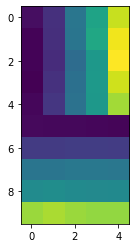

In [135]:
plt.imshow(outputs[-1].reshape(10,5))

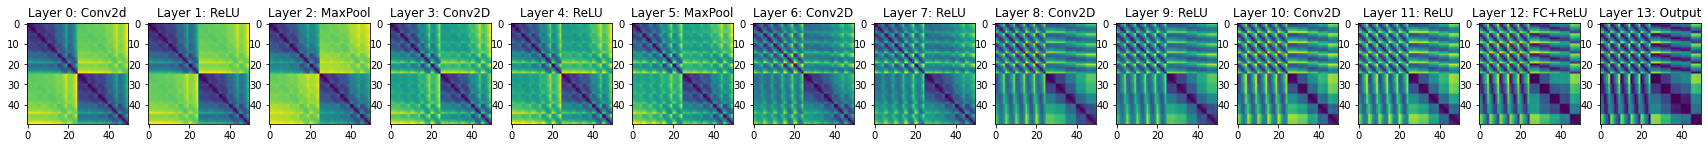

In [136]:
layer_labels = ['Layer '+str(i)+': ' +l for i,l in enumerate(['Conv2d','ReLU','MaxPool','Conv2D','ReLU','MaxPool','Conv2D','ReLU','Conv2D','ReLU','Conv2D','ReLU','FC+ReLU','Output'])]
f,axs = plt.subplots(1,len(layer_labels),figsize=(30,10))
for l,ax,rdm in zip(layer_labels,axs,rdms):
    ax.imshow(rdm[:,:])
    ax.set_title(l)

In [29]:
# ditto but wiht large weight init
def lazy_init(m):
    if isinstance(m,torch.nn.Conv2d):
        # print(m.__class__.__name__)
        torch.nn.init.normal_(m.weight,mean=0,std=0.1)
    elif isinstance(m,torch.nn.Linear):
        # print(m.__class__.__name__)
        torch.nn.init.normal_(m.weight,mean=0,std=0.02)
        torch.nn.init.zeros_(m.bias)

nnet = CustomAlexNet(pretrained=False)
_ = nnet.apply(lazy_init)
torch.nn.init.normal_(nnet.o.weight,mean=0,std=0.001)
torch.nn.init.zeros_(nnet.o.bias)


layerstoplot = [0,3,6,8,10]
for i in layerstoplot:
    w = nnet.features[i].weight.cpu().detach().numpy()
    print(f'layer{i}, norm: {np.linalg.norm(w.flatten())}') 
w = nnet.fc1.weight.cpu().detach().numpy()
print(f'layer fc1, norm: {np.linalg.norm(w.flatten())}') 

w = nnet.o.weight.cpu().detach().numpy()
print(f'layer o, norm: {np.linalg.norm(w.flatten())}')

layer0, norm: 15.17803955078125
layer3, norm: 55.4505500793457
layer6, norm: 81.48278045654297
layer8, norm: 94.06944274902344
layer10, norm: 76.78021240234375
layer fc1, norm: 36.217491149902344
layer o, norm: 0.021973678842186928


In [30]:
# get params, override a few defaults
args = parser.parse_args(args=[])
args.device, _ = get_device(args.cuda)
args.datadir = '../../Data/Simulations/stimuli/'
args.n_epochs = 50
args.learning_rate = 1e-4


In [31]:
# train model 
results = train_cnn(args, nnet, [dl_train, dl_val, dl_tn, dl_ts])

Epoch: 1 	Training Loss: 2.6259 	Validation Loss: 0.4608 	Training Accuracy: 0.664 	Validation Accuracy: 0.793 	 Task A 0.766 	 Task B 0.796 
Epoch: 2 	Training Loss: 0.1041 	Validation Loss: 0.3082 	Training Accuracy: 0.790 	Validation Accuracy: 0.800 	 Task A 0.785 	 Task B 0.799 
Epoch: 3 	Training Loss: 0.0760 	Validation Loss: 0.2424 	Training Accuracy: 0.795 	Validation Accuracy: 0.798 	 Task A 0.781 	 Task B 0.800 
Epoch: 4 	Training Loss: 0.0609 	Validation Loss: 0.2237 	Training Accuracy: 0.796 	Validation Accuracy: 0.803 	 Task A 0.791 	 Task B 0.800 
Epoch: 5 	Training Loss: 0.0553 	Validation Loss: 0.2524 	Training Accuracy: 0.797 	Validation Accuracy: 0.795 	 Task A 0.771 	 Task B 0.800 
Epoch: 6 	Training Loss: 0.0503 	Validation Loss: 0.2122 	Training Accuracy: 0.797 	Validation Accuracy: 0.803 	 Task A 0.789 	 Task B 0.800 
Epoch: 7 	Training Loss: 0.0455 	Validation Loss: 0.2113 	Training Accuracy: 0.797 	Validation Accuracy: 0.803 	 Task A 0.790 	 Task B 0.800 
Epoch:

In [33]:

layerstoplot = [0,3,6,8,10]
for i in layerstoplot:
    w = nnet.features[i].weight.cpu().detach().numpy()
    print(f'layer{i}, norm: {np.linalg.norm(w.flatten())}') 
w = nnet.fc1.weight.cpu().detach().numpy()
print(f'layer fc1, norm: {np.linalg.norm(w.flatten())}') 

w = nnet.o.weight.cpu().detach().numpy()
print(f'layer o, norm: {np.linalg.norm(w.flatten())}')

layer0, norm: 15.184062004089355
layer3, norm: 55.52674102783203
layer6, norm: 81.59735107421875
layer8, norm: 94.2992172241211
layer10, norm: 76.95857238769531
layer fc1, norm: 37.57965850830078
layer o, norm: 0.029638346284627914


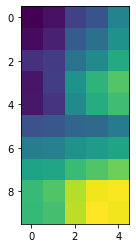

In [32]:
args = parser.parse_args(args=[])
args.device='cuda'
outputs,rdms = perform_rsa_cnn(args,nnet)

plt.imshow(outputs[-1].reshape(10,5))

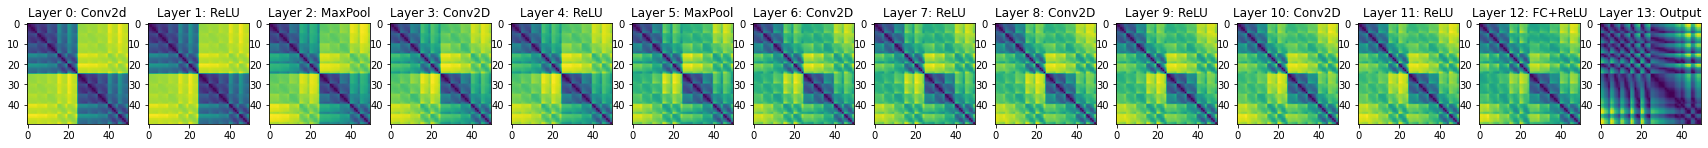

In [34]:
layer_labels = ['Layer '+str(i)+': ' +l for i,l in enumerate(['Conv2d','ReLU','MaxPool','Conv2D','ReLU','MaxPool','Conv2D','ReLU','Conv2D','ReLU','Conv2D','ReLU','FC+ReLU','Output'])]
f,axs = plt.subplots(1,len(layer_labels),figsize=(30,10))
for l,ax,rdm in zip(layer_labels,axs,rdms):
    ax.imshow(rdm[:,:])
    ax.set_title(l)